# Query matching
In this notebook I will query images from the cornershop dataset and we will look for simular embeddings in the embedding gallary. The goal is to end up with a top 5,10 of matches.

In [1]:
%matplotlib inline

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid #imagegrids for visualizing the top 10 matches
import PIL
from PIL import Image
from load_vissl_model import load_model #self defined function to reconstruct a vissl model
from pathlib import Path

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Loading embedding gallary
First we'll load a vissl model to use for inference:

In [45]:
#Specify the model below! Possible options are:
#"rotnet", "jigsaw", "moco32", "moco64", "simclr" and "swav"
#gallaries form checkpoints of the models are also available e.g. rotnet_phase25
model_name = "rotnet_phase100"
model = load_model(model_name, verbose=True)
model = model.eval()

#checking for the best device to run model on
device = torch.device("cpu") 
# if(torch.cuda.is_available()):
#     device = torch.device("cuda")
#     model.to(device) #move model to gpu
print(f"using {device} device", end="\n\n")

In function load_model()
Train config at (relative path from vissl/...):
validation/rotnet_full/train_config.yaml
SSL pretrained weights at:
/home/olivier/Documents/master/mp/checkpoints/sku110k/rotnet_full/model_phase100.torch

Model rotnet_phase100 was succusfully build
Weights for model rotnet_phase100 succesfully loaded
using cpu device



Now let's load the embedding gallary for this model:

In [46]:
#Gallary is stored in data folder with model_name as subfolder
dir = Path("data/" + model_name)

#Load torch stack of features
fts_stack = torch.load(dir / "embedding_gallary.torch")
print(f"fts_stack has shape {fts_stack.shape}")
print(f"Minimum value {fts_stack.min()}\nMaximum value {fts_stack.max()}")
print(f"4 example tensors from this stack:\n{fts_stack[0:5]}", end="\n\n")

#Load torch stack of normalized features
fts_stack_norm = torch.load(dir / "embedding_gallary_norm.torch")
print(f"fts_stack_norm has shape {fts_stack_norm.shape}")
print(f"Minimum value {fts_stack_norm.min()}\nMaximum value {fts_stack_norm.max()}")
print(f"4 example tensors from this stack:\n{fts_stack_norm[0:5]}", end="\n\n")

#load label list
labels = list()
with open(dir / "embedding_gallary_labels.txt", "r") as f:
    labels = f.read().splitlines()
    print(f"labels list has length "+ str(len(labels)))
    print(f"4 examples from the label list are: {labels[0:4]}")

fts_stack has shape torch.Size([1643, 2048])
Minimum value 0.0
Maximum value 3.962704658508301
4 example tensors from this stack:
tensor([[0.0114, 0.1304, 0.1026,  ..., 0.0396, 0.0253, 0.1805],
        [0.0411, 0.1155, 0.2713,  ..., 0.1502, 0.0147, 0.2703],
        [0.1501, 0.0705, 0.1980,  ..., 0.0999, 0.0139, 0.3738],
        [0.1144, 0.2134, 0.1365,  ..., 0.3496, 0.4377, 0.0860],
        [0.1376, 0.0561, 0.0114,  ..., 0.0160, 0.0733, 0.1033]])

fts_stack_norm has shape torch.Size([1643, 2048])
Minimum value 0.0
Maximum value 0.32941728830337524
4 example tensors from this stack:
tensor([[0.0012, 0.0138, 0.0108,  ..., 0.0042, 0.0027, 0.0191],
        [0.0032, 0.0091, 0.0214,  ..., 0.0118, 0.0012, 0.0213],
        [0.0129, 0.0061, 0.0170,  ..., 0.0086, 0.0012, 0.0321],
        [0.0089, 0.0165, 0.0106,  ..., 0.0271, 0.0339, 0.0067],
        [0.0170, 0.0069, 0.0014,  ..., 0.0020, 0.0090, 0.0127]])

labels list has length 1643
4 examples from the label list are: ['CawstonDry', 'CawstonDr

## Quering an image from CornerShop

In [47]:
#import the feature extraction method from the script that made the gallary
from embedding_gallary import extract_features

Collect the images:

In [48]:
#path where images are stored 
CornerShop = Path("/home/olivier/Documents/master/mp/CornerShop/CornerShop/crops")
img_paths = CornerShop.glob("*/*.jpg")
query_idx = -1

Query idx is 0, labels[0]=CawstonDry
Reading image at /home/olivier/Documents/master/mp/CornerShop/CornerShop/crops/CawstonDry/p40_0016.jpg


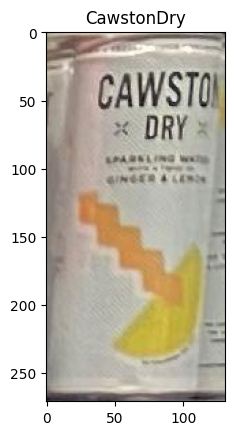

In [49]:
img_path = next(img_paths) #cycing trough the cornershop image dataset
query_idx+=1 #next label in list
label = img_path.parent.stem #extracting foldername as label for image
print(f"Query idx is {query_idx}, labels[{query_idx}]={labels[query_idx]}")
print(f"Reading image at {img_path}")
img = Image.open(img_path)
plt.title(label)
plt.imshow(img)

Calculate the embedding with the vissl model:

In [50]:
print(img_path)
img_fts = extract_features(img_path,model,verbose=True)
print(f"feature vector has shape {img_fts.shape}")
print(f"The embedding vector looks like this: {img_fts}")
print(f"The perfect match is present in the gallary: {fts_stack[query_idx]}")

/home/olivier/Documents/master/mp/CornerShop/CornerShop/crops/CawstonDry/p40_0016.jpg
Features extracted have the shape: torch.Size([2048])
feature vector has shape torch.Size([2048])
The embedding vector looks like this: tensor([0.0114, 0.1304, 0.1026,  ..., 0.0396, 0.0253, 0.1805])
The perfect match is present in the gallary: tensor([0.0114, 0.1304, 0.1026,  ..., 0.0396, 0.0253, 0.1805])


In [9]:
#calulating the normalized features for our image
norm = img_fts.norm(dim=0,keepdim=True)
img_fts_norm = img_fts / norm

## Matching the query embedding to the gallary
In summary we have:
- The calculated embedding `img_fts` of our query image (as a torch.Tensor)
- The calculated normalized embedding `img_fts_norm` of our query image (as a torch.Tensor)
- The `query_idx`, which represents the index of our query embedding in the gallary embedding
- The `label` containing the ground truth for classification
- The embedding gallary `fts_stack` (as a torch.Tensor)
- The normalized embedding gallary `fts_stack_norm` (as a torch.Tensor)

Our goal is to match the query embedding to the best match in the gallary

In [10]:
#Converting our gallary to numpy arrays
fts_stack_np = fts_stack.numpy()
fts_stack_norm_np = fts_stack_norm.numpy()
#Converting our img_fts to numpy array
img_fts_np = img_fts.numpy()
img_fts_norm_np = img_fts_norm.numpy()
print("Conversion to numpy arrays succesfull")
print(f"dtype fts_stack_np={type(fts_stack_np)}\ndtype fts_stack_norm_np={type(fts_stack_norm_np)}")
print(f"dtype img_fts_np={type(img_fts_np)}")
print(f"dtype img_fts_norm_np={type(img_fts_norm_np)}")

Conversion to numpy arrays succesfull
dtype fts_stack_np=<class 'numpy.ndarray'>
dtype fts_stack_norm_np=<class 'numpy.ndarray'>
dtype img_fts_np=<class 'numpy.ndarray'>
dtype img_fts_norm_np=<class 'numpy.ndarray'>


In [11]:
#visualization for the matching results:
def show_top10(top10):
    """ Makes an imagegrid of the top 10 matches:
        Args:
            top10 : Array with indicis of the top10 matching embeddings from the gallary
    """
    #visualizing the top10
    top10_matches = [list(CornerShop.glob("*/*.jpg"))[i] for i in top10]
    imgs = [Image.open(top10_matches[i]) for i in range(len(top10_matches))]
    #creating matlab figure
    fig = plt.figure(figsize=(10., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                     axes_pad=0.4,  # pad between axes in inch.
                     )
    i=1
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.set_title(f"Match #{i}")
        ax.imshow(im)
        i+=1

    plt.show()

In [12]:
def calc_top10(sim_vector, reverse_sort=True):
    """
    Extracts the top10 matches out of a simularity vector.
    This is done by performing an argsort on sim_vector.
    The result of argsort is returned.
    
    Args:
        sim_vector(np.array): simularity vector containing simularity scores with the query
        reverse_sort(boolean): True if higher simularity scores are considered better, False
        if lower simularity scores are considered better (e.g. euclidian distance, lower is better)
    """
    argsort_vector = np.argsort(sim_vector)
    if reverse_sort:
        #reverse order so best match is at the front of the array
        argsort_vector = argsort_vector[::-1] 
    #print("Top 10 matches with inner product as metric are:\n")
    top10 = argsort_vector[0:10]
    #print(top10, end="\n\n")
    print("Top10 label matches:")
    for rank,label_idx in enumerate(top10):
        print(f"{rank+1}.{labels[label_idx]}")
    print(f"\nGroud Truth = {label}")
    return top10

### Inner product (ip)

In [13]:
#Calulating the inner product of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_np.shape} x fts_stack.T {fts_stack_np.T.shape}")
sim_vector_ip =  np.matmul(img_fts_np, fts_stack_np.T) #multiply the img_fts_np with every embedding in the gallary 
#The simularity vector contains a score that expresses how simular the query embedding 
#for each embedding in the embedding gallary
print(f"The sim_vector_ip looks like this: {sim_vector_ip}")
print(f"min     {sim_vector_ip.min()}")
print(f"max     {sim_vector_ip.max()}")
print(f"avg     {sim_vector_ip.mean()}")
print(f"std dev {sim_vector_ip.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [1.2647952 1.1640972 1.130169  ... 1.1053876 1.0179892 1.1443595]
min     0.47191211581230164
max     1.7799105644226074
avg     1.022605538368225
std dev 0.14704319834709167


In [14]:
top10 = calc_top10(sim_vector_ip)

Top10 label matches:
1.RedBullOriginalBlik8x250ml
2.RedBullOriginalBlik4x250ml
3.Bacardi
4.JupilerBlik6x35,5cl
5.RedBullOriginalBlik8x250ml
6.RedBullOriginalBlik4x250ml
7.RedBullOriginalBlik4x250ml
8.RedBullOriginalBlik4x250ml
9.RedBullSugarFree4x250ml
10.JupilerBlik6x35,5cl

Groud Truth = CawstonDry


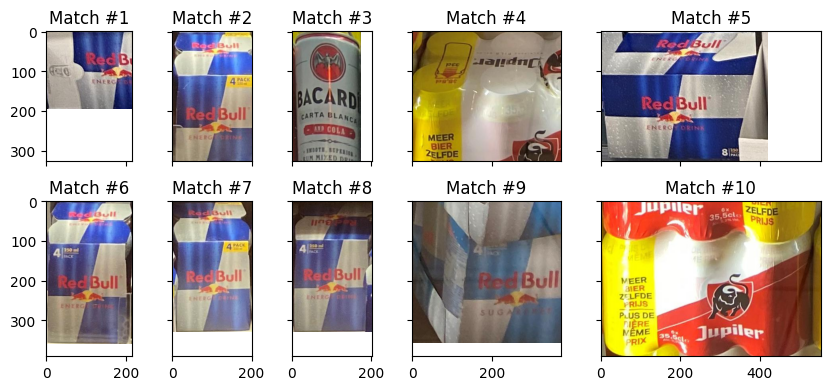

In [15]:
show_top10(top10=top10)

### Cosine simularity (cosim)

In [16]:
#Calulating the cosine simularity of the query and all the embeddings in the gallary
print(f"img_fts_norm {img_fts_norm_np.shape} x fts_stack_norm.T {fts_stack_norm_np.T.shape}")
sim_vector_cosim =  np.matmul(img_fts_norm_np, fts_stack_norm_np.T)  
print(f"The sim_vector_ip looks like this: {sim_vector_cosim}")
print(f"min     {sim_vector_cosim.min()}")
print(f"max     {sim_vector_cosim.max()}")
print(f"avg     {sim_vector_cosim.mean()}")
print(f"std dev {sim_vector_cosim.std()}")

img_fts_norm (2048,) x fts_stack_norm.T (2048, 1643)
The sim_vector_ip looks like this: [0.71445876 0.7048716  0.70700884 ... 0.61249393 0.6352789  0.62039566]
min     0.3591224253177643
max     0.7577275037765503
avg     0.6070002913475037
std dev 0.06311476975679398


In [17]:
top10 = calc_top10(sim_vector_cosim)

Top10 label matches:
1.TeisseireMojito
2.VolvicHibiscusTea37cl
3.HonestOriginalLemonade
4.ChaudfontaineSensation
5.VolvicHibiscusTea37cl
6.LiptonOriginalSparklingBlik
7.FuzeTeaLimeMint400ml
8.VolvicHibiscusTea37cl
9.VolvicRooibosTea37cl
10.FuzeTeaMangoChamomileFles400ml

Groud Truth = CawstonDry


In [26]:
# print(fts_stack_norm_np[top10[0]])
# print()
print(img_fts_np)
print()
print(fts_stack_np[query_idx])
print() 
print(img_fts_norm_np)
print()
print(fts_stack_norm_np[query_idx])
print()   
print((fts_stack_norm_np[query_idx] - img_fts_norm_np).sum())
print(fts_stack[0].norm(dim=0, keepdim=True))
print(fts_stack.norm(dim=1, keepdim=True))
tensor1 = torch.Tensor([[2.0], [4.0], [6.0], [8.0], [10.0]])
tensor2 = torch.Tensor([
    [2.0, 2.0, 2.0, 2.0, 2.0],
    [4.0, 4.0, 4.0, 4.0, 4.0],
    [6.0, 6.0, 6.0, 6.0, 6.0],
    [8.0, 8.0, 8.0, 8.0, 8.0],
    [10.0, 10.0, 10.0, 10.0, 10.0],
])
tensor3 = tensor2 / tensor1
print(tensor3)
print(fts_stack.size())

[0.00961432 0.01844793 0.04878343 ... 0.01898492 0.01661821 0.02579034]

[0.00502073 0.01791665 0.07874619 ... 0.0144962  0.01209777 0.04788124]

[0.00964792 0.0185124  0.04895392 ... 0.01905127 0.01667628 0.02588047]

[0.00282623 0.01008552 0.04432728 ... 0.00816011 0.00680999 0.02695299]

-11.764286
tensor([1.7765])
tensor([[1.7765],
        [1.6573],
        [1.6041],
        ...,
        [1.8110],
        [1.6080],
        [1.8510]])
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
torch.Size([1643, 2048])


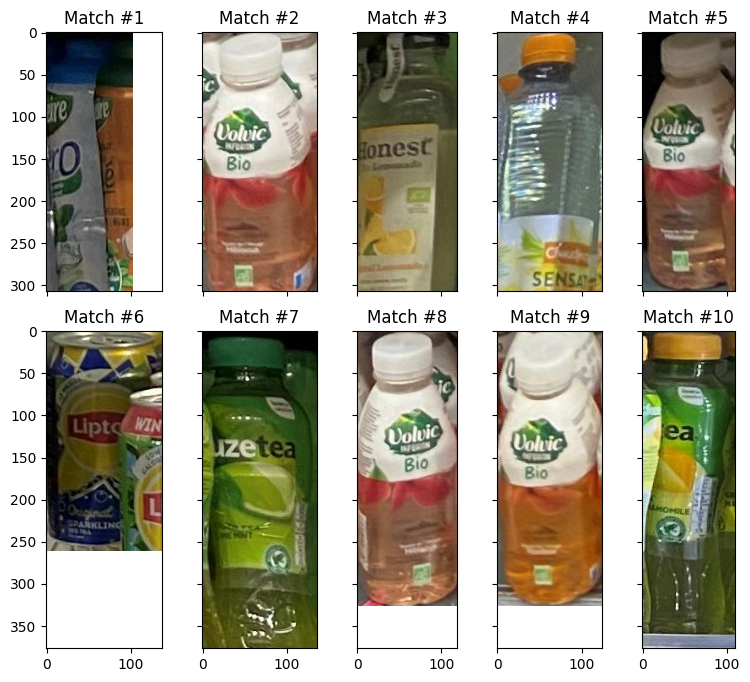

In [19]:
show_top10(top10=top10)

### Euclidian distance

In [20]:
eucl_dist = [] 
for gallary_embedding in fts_stack_np:
    #d(image_galary_embed, gallary_embedding)=euclid distance
    d_img_galemb = np.sqrt(np.sum(np.power(img_fts_np - gallary_embedding, 2))) 
    eucl_dist.append(d_img_galemb)
    
sim_vector_eucl_dist = np.array(eucl_dist)
print(f"The sim_vector_eucl_dist looks like this: {sim_vector_eucl_dist}")
print(f"min     {sim_vector_eucl_dist.min()}")
print(f"max     {sim_vector_eucl_dist.max()}")
print(f"avg     {sim_vector_eucl_dist.mean()}")
print(f"std dev {sim_vector_eucl_dist.std()}")


The sim_vector_eucl_dist looks like this: [1.2725215 1.1880292 1.1427464 ... 1.436014  1.2421057 1.4596456]
min     0.8659504055976868
max     4.708492755889893
avg     1.3621925115585327
std dev 0.30627620220184326


In [21]:
top10 = calc_top10(sim_vector_eucl_dist, reverse_sort=False)

Top10 label matches:
1.FuzeTeaLimeMint400ml
2.InnocentOrangeWithBits
3.TeisseireThe
4.FireflyLemonLimeGinger
5.FireflyLemonLimeGinger
6.ActiveO2OrangeLemon
7.FireflyLemonLimeGinger
8.MayTeaCitron1L
9.CharliesOrangeMandarin
10.InnocentApple

Groud Truth = CawstonDry


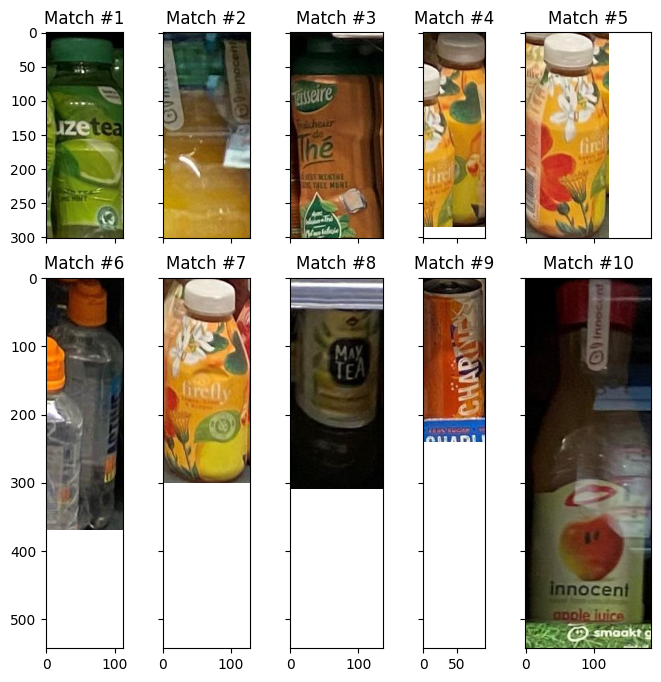

In [22]:
show_top10(top10=top10)

### Euclidian distance (normalized features)

In [23]:
eucl_dist_norm = [] 
for gallary_embedding in fts_stack_norm_np:
    #d(image_galary_embed, gallary_embedding)=euclid distance
    d_img_galemb = np.sqrt(np.sum(np.power(img_fts_norm_np - gallary_embedding, 2))) 
    eucl_dist_norm.append(d_img_galemb)
    
sim_vector_eucl_dist_norm = np.array(eucl_dist_norm)
print(f"The sim_vector_eucl_dist looks like this: {sim_vector_eucl_dist_norm}")
print(f"min     {sim_vector_eucl_dist_norm.min()}")
print(f"max     {sim_vector_eucl_dist_norm.max()}")
print(f"avg     {sim_vector_eucl_dist_norm.mean()}")
print(f"std dev {sim_vector_eucl_dist_norm.std()}")

The sim_vector_eucl_dist looks like this: [0.7557007  0.7682825  0.7654945  ... 0.880348   0.85407406 0.871326  ]
min     0.6960933804512024
max     1.1321465969085693
avg     0.883781909942627
std dev 0.07021068781614304


In [24]:
top10 = calc_top10(sim_vector_eucl_dist_norm, reverse_sort=False)

Top10 label matches:
1.TeisseireMojito
2.VolvicHibiscusTea37cl
3.HonestOriginalLemonade
4.ChaudfontaineSensation
5.VolvicHibiscusTea37cl
6.LiptonOriginalSparklingBlik
7.FuzeTeaLimeMint400ml
8.VolvicHibiscusTea37cl
9.VolvicRooibosTea37cl
10.FuzeTeaMangoChamomileFles400ml

Groud Truth = CawstonDry


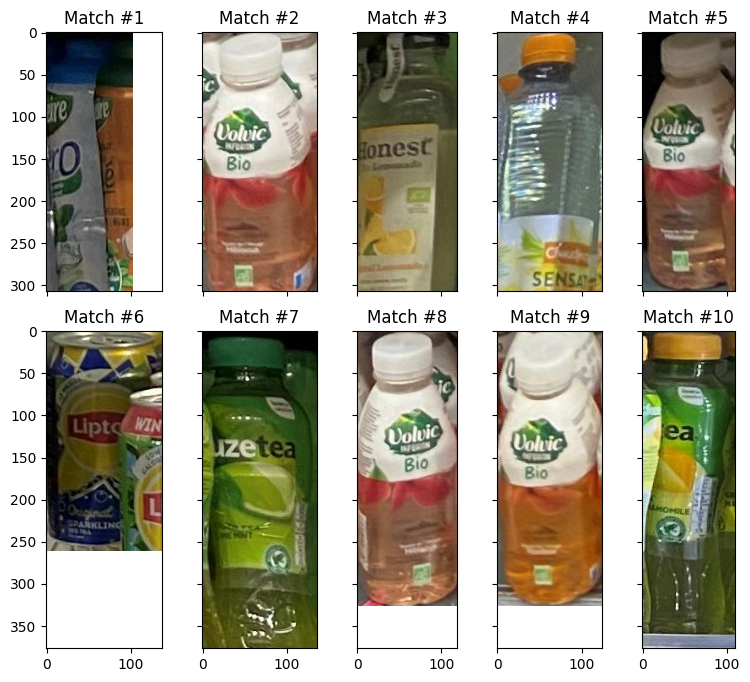

In [25]:
show_top10(top10=top10)